# BOB - the Big-Ole-Budget
## Objective: We hope to 
#### a) find the relative magnitudes of sources and sinks of carbon in the system
#### b) check if the found sources and sinks account for the changing carbon balance of the system as reported by the model


## BUDGET run specs:

    
    run dir: SS-run-sets/SalishSea/nemo3.6/tereza/FUTURE_runs/BUDGET_2017_RUN
    branch of run dir: TJSJ_future_runs
    config dir: NEMO-3.6-code/NEMOGCM/CONFIG/SalishSeaCast
    branch of config dir: TJSJ_future_forprod
    results on graham: /scratch/tjarnik/BUDGET
    results on salish: /data/tjarniko/results/FUTURE_runs/BUDGET/01jan17_RIVTA5/
    run suffix: RIVTA5
    
Equivalence notebook: 

http://localhost:8802/notebooks/notebooks/RIVER_PAPER/BUDGET/equivalence_check-RIVTA_and_PRDREM_METRICS.ipynb
    
   


In [8]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [9]:
import numpy as np
# import xarray as xr
import matplotlib.pyplot as plt
# from matplotlib.patches import Rectangle
# from mpl_toolkits.basemap import Basemap
# from scipy.io import loadmat
from cmocean import cm
import pandas as pd
import warnings
import pickle
import arrow
#from cartopy import crs, feature
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from salishsea_tools import viz_tools
import netCDF4 as nc
import glob
from decimal import Decimal

#import LambertConformalTicks as lct

%matplotlib inline
plt.rcParams['font.size'] = 11
warnings.simplefilter('ignore')


## Start budgeting

Governing source-sink equations of the system (as written in MM16/Jarnikova20whatever):

$\frac{\partial DIC}{\partial t } = - (U_{N} + U_{PC} - Rm_{N}) * R_{C:N} + {physical transport} + {airsea flux} $ 

$\frac{\partial TA}{\partial t } = U_{NO3-} - 2Rm_{NO3-} - U_{NH4+} + Rm_{NH4+} + (U_{PO4} + Rm_{PO4})* R_{N:P} + {physical transport}$ 


Decision i've made: 

    - everything calculated 20 grid cells (10 km) in from boundary


- things we need: 

- carbon content of domain daily (mmol)
            - one way to get that is (daily average DIC) * (e1t*e2t*e3t)
            - one way to get that is through DIC_e3tsnap * (e1t*e2t)
                -instantaneous-at-END-of-day DIC concentration * e3t at that time (changes due to tidal range)
- change in daily carbon content (subtract daily values of the above)

this change should be equal to the sum of the daily totals of:

- river carbon input (RIV_DIC (mmol/s))
- carbon taken up by phytoplankton (mmol/s)
- carbon remineralized (mmol/s)
- carbon going through the western boundary (mmol/s)
- carbon going through the northern boundary (mmol/s)
- carbon going through the air-sea boundary (air_sea_carbon * e1t*e2t, mmol/s)

            

In [10]:
print('hm')

hm


In [11]:
# dimensional conversion variables 

#meshmask
mmk = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
e2t = (mmk['e2t'][0,:,:])
e1t = (mmk['e1t'][0,:,:])
surfar_m2 = e1t * e2t
tmask_orig = mmk['tmask'][0,:,:,:]
tmask = (mmk['tmask'][0,:,:,:])

# cut edges
tmask[:,878:898,:] = 0
tmask[:,:,0:20] = 0

surfar_m2[878:898,:] = 0
surfar_m2[:,0:20] = 0

surfar_m2_broad = np.zeros([40,898,398])

for i in range(0,40):
    surfar_m2_broad[i,:,:] = surfar_m2

surfar_m2_mask = surfar_m2_broad * tmask

#seconds in day
sid = 60*60*24

### notes and variables for conversion

    sid --- seconds in day, 86400
    surfar_m2_broad --- surface area of cell in m2 * tmask (20 grid cells from left and top edge cut), 40x898x398
    tmask --- 40x898x398 (20 grid cells from left and top edge cut)
    1 m3 = 1e-9 km3

In [24]:
## open relevant files - test with one day

daystr = '20170101'
q4 = '/data/tjarniko/results/FUTURE_runs/BUDGET/*_RIVTA5/'

prdrem = glob.glob(f'{q4}*_1d_*_PRDREM_T_{daystr}-{daystr}.nc')
prdrem_boi = nc.Dataset(prdrem[0])
carp = glob.glob(f'{q4}*_1d_*_carp_T_{daystr}-{daystr}.nc')
carp_boi = nc.Dataset(carp[0])
dianu = glob.glob(f'{q4}*_1d_*_dian_U_{daystr}-{daystr}.nc')
dianu_boi = nc.Dataset(dianu[0])
dianv = glob.glob(f'{q4}*_1d_*_dian_V_{daystr}-{daystr}.nc')
dianv_boi = nc.Dataset(dianv[0])

#### function to get BOB numbers out, option to print with sci. not. 

In [25]:

### function to get bob numbers

def find_bob_numbers(daystr, verbose = True):
    
    q4 = '/data/tjarniko/results/FUTURE_runs/NEWBUDGET/*_RIVTA5/'

    prdrem = glob.glob(f'{q4}*_1d_*_PRDREM_T_{daystr}-{daystr}.nc')
    prdrem_boi = nc.Dataset(prdrem[0])
    carp = glob.glob(f'{q4}*_1d_*_carp_T_{daystr}-{daystr}.nc')
    carp_boi = nc.Dataset(carp[0])
    dianu = glob.glob(f'{q4}*_1d_*_dian_U_{daystr}-{daystr}.nc')
    dianu_boi = nc.Dataset(dianu[0])
    dianv = glob.glob(f'{q4}*_1d_*_dian_V_{daystr}-{daystr}.nc')
    dianv_boi = nc.Dataset(dianv[0])

    e3t = carp_boi['e3t'][0,:,:,:]
    vol_m3 = surfar_m2_mask * e3t 
    vol_km3_tot = np.nansum(vol_m3) * 1e-9
    
    ## TOTAL DIC IN SYSTEM IN MMOLS
    e3t = carp_boi['e3t'][0,:,:,:]
    DIC = carp_boi['dissolved_inorganic_carbon'][0,:,:,:]
    DIC_mmol = DIC * e3t* surfar_m2_mask 
    DIC_mmol_tot = np.nansum(DIC_mmol)

    DIC_SNAP = carp_boi['DIC_E3TSNAP'][0,:,:,:]
    DIC_SNAP_mmol = DIC_SNAP * surfar_m2_mask 
    DIC_SNAP_mmol_tot = np.nansum(DIC_SNAP_mmol)

    #### total DIC input in rivers
    # ?? when multiply river_DIC by tmask, stuff gets cut out? tthere must be a river coming in near the boundary 

    riverine_DIC = prdrem_boi['riverine DIC'][0,:,:,:]  * tmask
    riv_DIC_mmol_day_tot = np.nansum(riverine_DIC) * sid
    
    ### total DIC taken up by production 
    PRD_DIC = prdrem_boi['PRD DIC'][0,:,:,:]  * tmask
    PRD_DIC_mmol_day_tot = np.nansum(PRD_DIC) * sid 

    UNC_DIC = prdrem_boi['Uncoupled DIC uptake'][0,:,:,:]  * tmask
    UNC_DIC_mmol_day_tot = np.nansum(UNC_DIC) * sid * (-1)
    ### total DIC remineralized
    REM_DIC = prdrem_boi['REM DIC'][0,:,:,:]  * tmask
    REM_DIC_mmol_day_tot = np.nansum(REM_DIC) * sid 

    DIC_UT = dianu_boi['DIC_UT'][0,:,:,20] * sid 
    DIC_UT_mmol_day_pos = np.nansum(DIC_UT[DIC_UT>=0])
    DIC_UT_mmol_day_neg = np.nansum(DIC_UT[DIC_UT<=0])
    DIC_UT_mmol_day_tot = np.nansum(DIC_UT) 

    ## this is johnstone strait. negative is INTO DOMAIN
    DIC_VT = dianv_boi['DIC_VT'][0,:,878,0:100] * (-1)  * sid 
    DIC_VT_mmol_day_pos = np.nansum(DIC_VT[DIC_VT>=0])
    DIC_VT_mmol_day_neg = np.nansum(DIC_VT[DIC_VT<=0])
    DIC_VT_mmol_day_tot = np.nansum(DIC_VT)

    ASflux = carp_boi['co2_flux_mmol_m2_s'][0,:,:]
    ASflux_mmol_day_tot = np.nansum(ASflux* surfar_m2_mask[0,:,:]) *sid

    #daychange = 
    daychange = ASflux_mmol_day_tot + DIC_VT_mmol_day_tot + DIC_UT_mmol_day_tot + \
    REM_DIC_mmol_day_tot + PRD_DIC_mmol_day_tot + riv_DIC_mmol_day_tot 
    
    if verbose:
        print(f'day is {daystr}')
        print('km3 water in system (day average):')
        print(f"{Decimal(vol_km3_tot):.8E}")

        print('')
        print('mmols DIC in system (day average):')
        print(f"{Decimal(DIC_mmol_tot):.8E}")
        print('mmols DIC in system (snapshot at midnight):')
        print(f"{Decimal(DIC_SNAP_mmol_tot):.8E}")

        print('')
        print('DIC coming in through rivers (mmol/day):')
        print(f"{Decimal(riv_DIC_mmol_day_tot):.8E}")

        print('DIC taken up by phyto (mmol/day):')
        print(f"{Decimal(PRD_DIC_mmol_day_tot):.8E}")

        print('UNCOUPLED DIC taken up by phyto (mmol/day):')
        print(f"{Decimal(UNC_DIC_mmol_day_tot):.8E}")

        print('DIC remineralized! (mmol/day):')
        print(f"{Decimal(REM_DIC_mmol_day_tot):.8E}")

        print('DIC through western JDF boundary (+ = in, to the east, mmol/day)')
        print(f"{Decimal(DIC_UT_mmol_day_tot):.8E}")

        print('DIC through northern JS boundary (+ = in, to the south, mmol/day)')
        print(f"{Decimal(DIC_VT_mmol_day_tot):.8E}")

        print('Air-sea flux (+ = in, from air to sea, mmol/day)')
        print(f"{Decimal(ASflux_mmol_day_tot):.8E}")

        print('')
        print('total change in DIC from all sources and sinks today (mmol/day):')
        print(f"{Decimal(daychange):.8E}")
    
    return vol_km3_tot, DIC_mmol_tot, DIC_SNAP_mmol_tot, riv_DIC_mmol_day_tot, PRD_DIC_mmol_day_tot, \
UNC_DIC_mmol_day_tot, REM_DIC_mmol_day_tot, \
DIC_UT_mmol_day_tot, DIC_VT_mmol_day_tot, ASflux_mmol_day_tot, daychange, \
DIC_UT_mmol_day_pos, DIC_VT_mmol_day_pos, \
DIC_UT_mmol_day_neg, DIC_VT_mmol_day_neg

vol_km3_tot, DIC_mmol_tot, DIC_SNAP_mmol_tot, riv_DIC_mmol_day_tot, PRD_DIC_mmol_day_tot, \
UNC_DIC_mmol_day_tot, REM_DIC_mmol_day_tot, DIC_UT_mmol_day_tot, \
DIC_VT_mmol_day_tot, ASflux_mmol_day_tot, daychange, DIC_UT_mmol_day_pos, DIC_VT_mmol_day_pos, \
DIC_UT_mmol_day_neg, DIC_VT_mmol_day_neg \
= find_bob_numbers(daystr, True)



# river carbon input (RIV_DIC (mmol/s))
# carbon taken up by phytoplankton (mmol/s)
# carbon remineralized (mmol/s)
# carbon going through the western boundary (mmol/s)
# carbon going through the northern boundary (mmol/s)
# carbon going through the air-sea boundary (air_sea_carbon * e1t*e2t, mmol/s)

day is 20170101
km3 water in system (day average):
2.27748225E+3

mmols DIC in system (day average):
4.76211265E+15
mmols DIC in system (snapshot at midnight):
4.77655899E+15

DIC coming in through rivers (mmol/day):
3.92174352E+11
DIC taken up by phyto (mmol/day):
-1.17300388E+11
UNCOUPLED DIC taken up by phyto (mmol/day):
-1.38855239E+7
DIC remineralized! (mmol/day):
6.67416888E+10
DIC through western JDF boundary (+ = in, to the east, mmol/day)
-7.02898323E+12
DIC through northern JS boundary (+ = in, to the south, mmol/day)
-8.35327153E+11
Air-sea flux (+ = in, from air to sea, mmol/day)
-3.32604833E+11

total change in DIC from all sources and sinks today (mmol/day):
-7.85529956E+12


## workhorse bob-getting-cell

In [26]:
start ='2017-01-01'
end ='2017-12-31'
runhorse = True
if runhorse:

    # end ='2017-01-02'


    start_run = arrow.get(start)
    end_run = arrow.get(end)

    arrow_array = []

    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)

    dayslen = len(arrow_array)

    vol_km3_tot_ar = np.zeros(dayslen); DIC_mmol_tot_ar = np.zeros(dayslen)
    DIC_SNAP_mmol_tot_ar = np.zeros(dayslen); 
    riv_DIC_mmol_day_tot_ar = np.zeros(dayslen); PRD_DIC_mmol_day_tot_ar = np.zeros(dayslen); 
    UNC_DIC_mmol_day_tot_ar = np.zeros(dayslen); REM_DIC_mmol_day_tot_ar = np.zeros(dayslen); 
    DIC_UT_mmol_day_tot_ar = np.zeros(dayslen); DIC_VT_mmol_day_tot_ar = np.zeros(dayslen); 
    DIC_UT_mmol_day_pos_ar = np.zeros(dayslen); DIC_VT_mmol_day_pos_ar = np.zeros(dayslen); 
    DIC_UT_mmol_day_neg_ar = np.zeros(dayslen); DIC_VT_mmol_day_neg_ar = np.zeros(dayslen); 
    ASflux_mmol_day_tot_ar = np.zeros(dayslen); daychange_mmol_day_tot_ar = np.zeros(dayslen)

    for i in range(0,dayslen):

        tdate = arrow_array[i][0]
        print(tdate)
        daystr = tdate.format('YYYYMMDD')

        vol_km3_tot, DIC_mmol_tot, DIC_SNAP_mmol_tot, \
        riv_DIC_mmol_day_tot, PRD_DIC_mmol_day_tot, \
        UNC_DIC_mmol_day_tot, REM_DIC_mmol_day_tot, \
        DIC_UT_mmol_day_tot, DIC_VT_mmol_day_tot, \
        ASflux_mmol_day_tot, daychange_mmol_day_tot,\
        DIC_UT_mmol_day_pos, DIC_VT_mmol_day_pos, \
        DIC_UT_mmol_day_neg, DIC_VT_mmol_day_neg \
        = find_bob_numbers(daystr, False)

        vol_km3_tot_ar[i] = vol_km3_tot; DIC_mmol_tot_ar[i] = DIC_mmol_tot; 
        DIC_SNAP_mmol_tot_ar[i] = DIC_SNAP_mmol_tot; riv_DIC_mmol_day_tot_ar[i] = riv_DIC_mmol_day_tot;
        PRD_DIC_mmol_day_tot_ar[i] = PRD_DIC_mmol_day_tot; UNC_DIC_mmol_day_tot_ar[i] = UNC_DIC_mmol_day_tot;
        REM_DIC_mmol_day_tot_ar[i] = REM_DIC_mmol_day_tot; DIC_UT_mmol_day_tot_ar[i] = DIC_UT_mmol_day_tot;
        DIC_VT_mmol_day_tot_ar[i] = DIC_VT_mmol_day_tot; ASflux_mmol_day_tot_ar[i] = ASflux_mmol_day_tot;
        daychange_mmol_day_tot_ar[i] = daychange_mmol_day_tot
        DIC_VT_mmol_day_neg_ar[i] = DIC_VT_mmol_day_neg
        DIC_VT_mmol_day_pos_ar[i] = DIC_VT_mmol_day_pos
        DIC_UT_mmol_day_neg_ar[i] = DIC_UT_mmol_day_neg
        DIC_UT_mmol_day_pos_ar[i] = DIC_UT_mmol_day_pos


    fn = f'BUDGETVARS_RIVTA5_{start}-{end}.nc'
    ds = nc.Dataset(fn, 'w', format='NETCDF4')

    days = ds.createDimension('days', dayslen)
    vol_km3_tot_ar_nc = ds.createVariable('vol_km3_tot_ar', 'f4', ('days',))
    vol_km3_tot_ar_nc[:] = vol_km3_tot_ar 
    DIC_mmol_tot_ar_nc = ds.createVariable('DIC_mmol_tot_ar', 'f4', ('days',))
    DIC_mmol_tot_ar_nc[:] = DIC_mmol_tot_ar 
    DIC_SNAP_mmol_tot_ar_nc = ds.createVariable('DIC_SNAP_mmol_tot_ar', 'f4', ('days',))
    DIC_SNAP_mmol_tot_ar_nc[:] = DIC_SNAP_mmol_tot_ar 
    riv_DIC_mmol_day_tot_ar_nc = ds.createVariable('riv_DIC_mmol_day_tot_ar', 'f4', ('days',))
    riv_DIC_mmol_day_tot_ar_nc[:] = riv_DIC_mmol_day_tot_ar 
    PRD_DIC_mmol_day_tot_ar_nc = ds.createVariable('PRD_DIC_mmol_day_tot_ar', 'f4', ('days',))
    PRD_DIC_mmol_day_tot_ar_nc[:] = PRD_DIC_mmol_day_tot_ar 
    UNC_DIC_mmol_day_tot_ar_nc = ds.createVariable('UNC_DIC_mmol_day_tot_ar', 'f4', ('days',))
    UNC_DIC_mmol_day_tot_ar_nc[:] = UNC_DIC_mmol_day_tot_ar 
    REM_DIC_mmol_day_tot_ar_nc = ds.createVariable('REM_DIC_mmol_day_tot_ar', 'f4', ('days',))
    REM_DIC_mmol_day_tot_ar_nc[:] = REM_DIC_mmol_day_tot_ar 
    DIC_UT_mmol_day_tot_ar_nc = ds.createVariable('DIC_UT_mmol_day_tot_ar', 'f4', ('days',))
    DIC_UT_mmol_day_tot_ar_nc[:] = DIC_UT_mmol_day_tot_ar 
    DIC_VT_mmol_day_tot_ar_nc = ds.createVariable('DIC_VT_mmol_day_tot_ar', 'f4', ('days',))
    DIC_VT_mmol_day_tot_ar_nc[:] = DIC_VT_mmol_day_tot_ar 
    ASflux_mmol_day_tot_ar_nc = ds.createVariable('ASflux_mmol_day_tot_ar', 'f4', ('days',))
    ASflux_mmol_day_tot_ar_nc[:] = ASflux_mmol_day_tot_ar 
    daychange_mmol_day_tot_ar_nc = ds.createVariable('daychange_mmol_day_tot_ar', 'f4', ('days',))
    daychange_mmol_day_tot_ar_nc[:] = daychange_mmol_day_tot_ar 
    DIC_VT_mmol_day_pos_ar_nc = ds.createVariable('DIC_VT_mmol_day_pos_ar', 'f4', ('days',))
    DIC_VT_mmol_day_pos_ar_nc[:] = DIC_VT_mmol_day_pos_ar 
    DIC_VT_mmol_day_neg_ar_nc = ds.createVariable('DIC_VT_mmol_day_neg_ar', 'f4', ('days',))
    DIC_VT_mmol_day_neg_ar_nc[:] = DIC_VT_mmol_day_neg_ar 
    DIC_UT_mmol_day_pos_ar_nc = ds.createVariable('DIC_UT_mmol_day_pos_ar', 'f4', ('days',))
    DIC_UT_mmol_day_pos_ar_nc[:] = DIC_UT_mmol_day_pos_ar 
    DIC_UT_mmol_day_neg_ar_nc = ds.createVariable('DIC_UT_mmol_day_neg_ar', 'f4', ('days',))
    DIC_UT_mmol_day_neg_ar_nc[:] = DIC_UT_mmol_day_neg_ar 


    ds.close()
    
else: 
    print('no running of extraction')

2017-01-01T00:00:00+00:00
2017-01-02T00:00:00+00:00
2017-01-03T00:00:00+00:00
2017-01-04T00:00:00+00:00
2017-01-05T00:00:00+00:00
2017-01-06T00:00:00+00:00
2017-01-07T00:00:00+00:00
2017-01-08T00:00:00+00:00
2017-01-09T00:00:00+00:00
2017-01-10T00:00:00+00:00
2017-01-11T00:00:00+00:00
2017-01-12T00:00:00+00:00
2017-01-13T00:00:00+00:00
2017-01-14T00:00:00+00:00
2017-01-15T00:00:00+00:00
2017-01-16T00:00:00+00:00
2017-01-17T00:00:00+00:00
2017-01-18T00:00:00+00:00
2017-01-19T00:00:00+00:00
2017-01-20T00:00:00+00:00
2017-01-21T00:00:00+00:00
2017-01-22T00:00:00+00:00
2017-01-23T00:00:00+00:00
2017-01-24T00:00:00+00:00
2017-01-25T00:00:00+00:00
2017-01-26T00:00:00+00:00
2017-01-27T00:00:00+00:00
2017-01-28T00:00:00+00:00
2017-01-29T00:00:00+00:00
2017-01-30T00:00:00+00:00
2017-01-31T00:00:00+00:00
2017-02-01T00:00:00+00:00
2017-02-02T00:00:00+00:00
2017-02-03T00:00:00+00:00
2017-02-04T00:00:00+00:00
2017-02-05T00:00:00+00:00
2017-02-06T00:00:00+00:00
2017-02-07T00:00:00+00:00
2017-02-08T0

2017-11-13T00:00:00+00:00
2017-11-14T00:00:00+00:00
2017-11-15T00:00:00+00:00
2017-11-16T00:00:00+00:00
2017-11-17T00:00:00+00:00
2017-11-18T00:00:00+00:00
2017-11-19T00:00:00+00:00
2017-11-20T00:00:00+00:00
2017-11-21T00:00:00+00:00
2017-11-22T00:00:00+00:00
2017-11-23T00:00:00+00:00
2017-11-24T00:00:00+00:00
2017-11-25T00:00:00+00:00
2017-11-26T00:00:00+00:00
2017-11-27T00:00:00+00:00
2017-11-28T00:00:00+00:00
2017-11-29T00:00:00+00:00
2017-11-30T00:00:00+00:00
2017-12-01T00:00:00+00:00
2017-12-02T00:00:00+00:00
2017-12-03T00:00:00+00:00
2017-12-04T00:00:00+00:00
2017-12-05T00:00:00+00:00
2017-12-06T00:00:00+00:00
2017-12-07T00:00:00+00:00
2017-12-08T00:00:00+00:00
2017-12-09T00:00:00+00:00
2017-12-10T00:00:00+00:00
2017-12-11T00:00:00+00:00
2017-12-12T00:00:00+00:00
2017-12-13T00:00:00+00:00
2017-12-14T00:00:00+00:00
2017-12-15T00:00:00+00:00
2017-12-16T00:00:00+00:00
2017-12-17T00:00:00+00:00
2017-12-18T00:00:00+00:00
2017-12-19T00:00:00+00:00
2017-12-20T00:00:00+00:00
2017-12-21T0

In [22]:
w = nc.Dataset('/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171226-20171226.nc')

print(w['e3t'])

w2 = nc.Dataset('/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171224-20171224.nc')

print(w['e3t'])

<class 'netCDF4._netCDF4.Variable'>
float32 e3t(time_counter, deptht, y, x)
    standard_name: cell_thickness
    long_name: T-cell thickness
    units: m
    online_operation: average
    interval_operation: 40 s
    interval_write: 1 d
    cell_methods: time: mean (interval: 40 s)
    cell_measures: area: area
    _FillValue: 1e+20
    missing_value: 1e+20
    coordinates: time_centered nav_lat nav_lon
unlimited dimensions: time_counter
current shape = (1, 40, 898, 398)
filling on
<class 'netCDF4._netCDF4.Variable'>
float32 e3t(time_counter, deptht, y, x)
    standard_name: cell_thickness
    long_name: T-cell thickness
    units: m
    online_operation: average
    interval_operation: 40 s
    interval_write: 1 d
    cell_methods: time: mean (interval: 40 s)
    cell_measures: area: area
    _FillValue: 1e+20
    missing_value: 1e+20
    coordinates: time_centered nav_lat nav_lon
unlimited dimensions: time_counter
current shape = (1, 40, 898, 398)
filling on


No handles with labels found to put in legend.


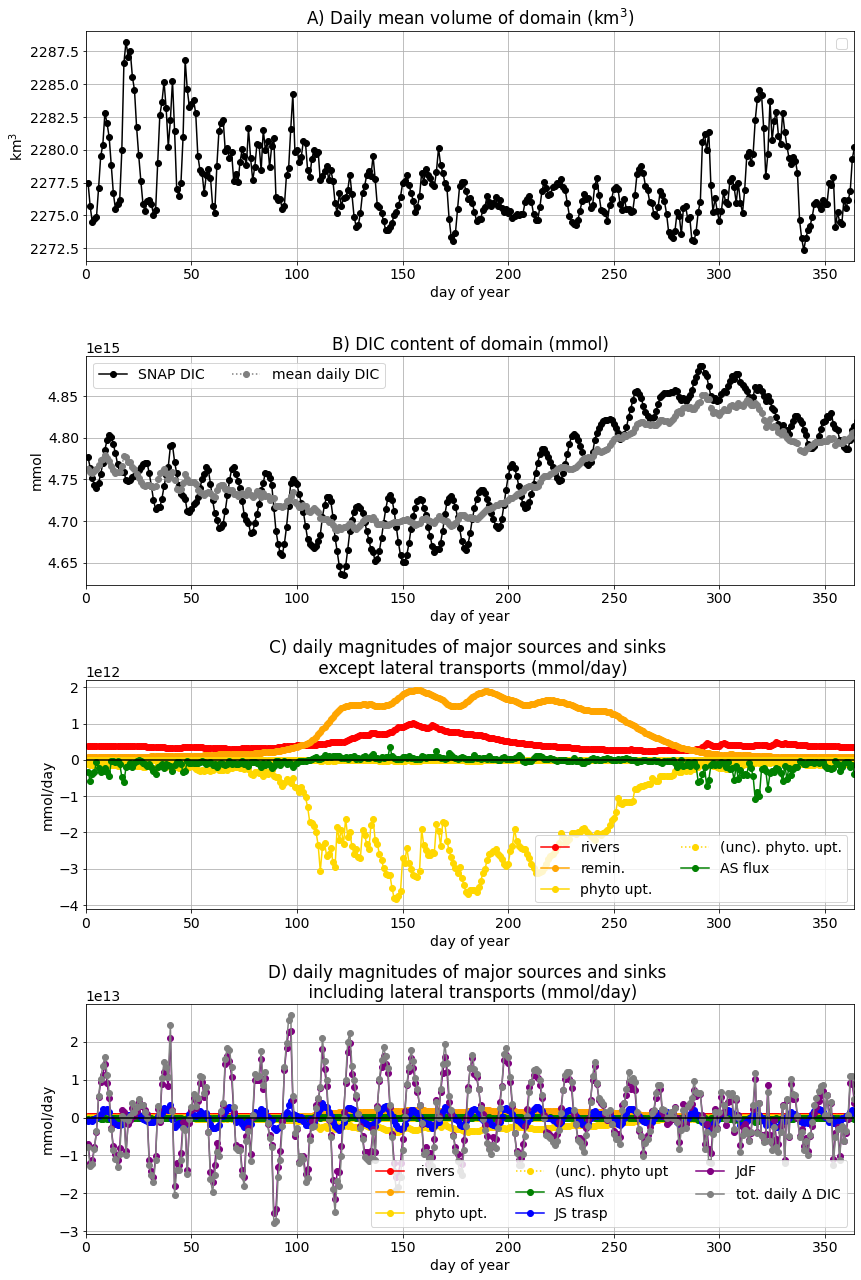

In [27]:
#rcparams
plt.rcParams.update({'font.size': 14})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 15}

#VARIABLES
# vol_km3_tot_ar ; DIC_mmol_tot_ar 
# DIC_SNAP_mmol_tot_ar ; 
# riv_DIC_mmol_day_tot_ar ; PRD_DIC_mmol_day_tot_ar ; 
# UNC_DIC_mmol_day_tot_ar ; REM_DIC_mmol_day_tot_ar ; 
# DIC_UT_mmol_day_tot_ar ; DIC_VT_mmol_day_tot_ar ; 
# ASflux_mmol_day_tot_ar ; daychange_mmol_day_tot_ar 
#end = '2017-03-01'
w = nc.Dataset(f'BUDGETVARS_RIVTA5_{start}-{end}.nc')
#w = nc.Dataset('BUDGETVARS_RIVTA5_2017-01-01-2017-03-01.nc')
# print(w)

## plotting
fact = 0.6
fig, axs = plt.subplots(4,1, figsize=(20*fact, 30*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
\
axs[0].plot(np.arange(1, dayslen+1,1),w['vol_km3_tot_ar'][:], color = 'k',linestyle = '-',  marker = 'o')
axs
axs[1].plot(np.arange(1, dayslen+1,1),w['DIC_SNAP_mmol_tot_ar'][:], color = 'k',linestyle = '-', marker = 'o', \
           label = 'SNAP DIC')
axs[1].plot(np.arange(1, dayslen+1,1),w['DIC_mmol_tot_ar'][:], color = 'grey',linestyle = ':', marker = 'o',\
             label = 'mean daily DIC')
#plot one to one line

axs[2].plot(np.arange(1, dayslen+1,1),w['riv_DIC_mmol_day_tot_ar'][:], color = 'r',linestyle = '-', marker = 'o', \
           label = 'rivers')

axs[2].plot(np.arange(1, dayslen+1,1),w['REM_DIC_mmol_day_tot_ar'][:], color = 'orange',linestyle = '-', marker = 'o', \
           label = 'remin.')

axs[2].plot(np.arange(1, dayslen+1,1),w['PRD_DIC_mmol_day_tot_ar'][:], color = 'gold',linestyle = '-', marker = 'o', \
           label = 'phyto upt.')
axs[2].plot(np.arange(1, dayslen+1,1),w['UNC_DIC_mmol_day_tot_ar'][:], color = 'gold',linestyle = ':', marker = 'o', \
           label = '(unc). phyto. upt.')

axs[2].plot(np.arange(1, dayslen+1,1),w['ASflux_mmol_day_tot_ar'][:], color = 'green',linestyle = '-', marker = 'o', \
           label = 'AS flux')

axs[2].axhline(y = 0, color = 'k')

# plt.yscale("log")
###
axs[3].plot(np.arange(1, dayslen+1,1),w['riv_DIC_mmol_day_tot_ar'][:], color = 'r',linestyle = '-', marker = 'o', \
           label = 'rivers')

axs[3].plot(np.arange(1, dayslen+1,1),w['REM_DIC_mmol_day_tot_ar'][:], color = 'orange',linestyle = '-', marker = 'o', \
           label = 'remin.')

axs[3].plot(np.arange(1, dayslen+1,1),w['PRD_DIC_mmol_day_tot_ar'][:], color = 'gold',linestyle = '-', marker = 'o', \
           label = 'phyto upt.')
axs[3].plot(np.arange(1, dayslen+1,1),w['UNC_DIC_mmol_day_tot_ar'][:], color = 'gold',linestyle = ':', marker = 'o', \
           label = '(unc). phyto upt')

axs[3].plot(np.arange(1, dayslen+1,1),w['ASflux_mmol_day_tot_ar'][:], color = 'green',linestyle = '-', marker = 'o', \
           label = 'AS flux ')

axs[3].plot(np.arange(1, dayslen+1,1),w['DIC_VT_mmol_day_tot_ar'][:], color = 'blue',linestyle = '-', marker = 'o', \
           label = 'JS trasp')

axs[3].plot(np.arange(1, dayslen+1,1),w['DIC_UT_mmol_day_tot_ar'][:], color = 'purple',linestyle = '-', marker = 'o', \
           label = 'JdF')

axs[3].plot(np.arange(1, dayslen+1,1),w['daychange_mmol_day_tot_ar'][:], color = 'grey',linestyle = '-', marker = 'o', \
           label = 'tot. daily $\Delta$ DIC')


axs[0].set_title('A) Daily mean volume of domain (km$^3$)'); 
axs[1].set_title('B) DIC content of domain (mmol)'); 
axs[2].set_title('C) daily magnitudes of major sources and sinks \n except lateral transports (mmol/day)'); 
axs[3].set_title('D) daily magnitudes of major sources and sinks \n including lateral transports (mmol/day)'); 

axs[0].set_ylabel('km$^3$'); 
axs[1].set_ylabel('mmol'); 
axs[2].set_ylabel('mmol/day'); 
axs[3].set_ylabel('mmol/day'); 


axs[3].axhline(y = 0, color = 'k')
for i in range(0,4):
    axs[i].grid()
    
    axs[i].set_xlim([0,dayslen-1])
    axs[i].set_xlabel('day of year')
    axs[i].legend(loc = 'best', ncol = 2)
    
axs[3].legend(loc = 'best', ncol = 3)
#axs[2].legend(loc = 'best')
#axs[3].legend(bbox_to_anchor = [1 , 1 ], fontsize = 14, ncol = 1)
plt.tight_layout()

#### Phytoplankton uptake and uncoupled phytoplankton uptake

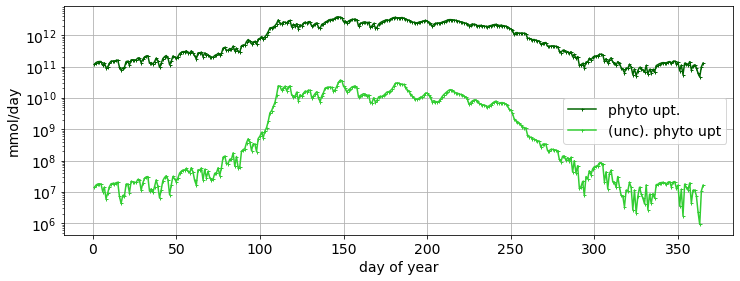

In [28]:
fact = 0.6
fig, axs = plt.subplots(1,1, figsize=(20*fact, 7*fact), facecolor='w', edgecolor='k')
# axs = axs.ravel()

axs.plot(np.arange(1, dayslen+1,1),-1*w['PRD_DIC_mmol_day_tot_ar'][:], color = 'darkgreen',linestyle = '-', marker = '+', markersize = 3,\
           label = 'phyto upt.')
axs.plot(np.arange(1, dayslen+1,1),-1*w['UNC_DIC_mmol_day_tot_ar'][:], color = 'limegreen',linestyle = '-', marker = '+', markersize = 3,\
           label = '(unc). phyto upt')


plt.yscale("log")
axs.grid()
axs.set_ylabel('mmol/day'); 
axs.set_xlabel('day of year'); 
plt.legend(loc = 'best')


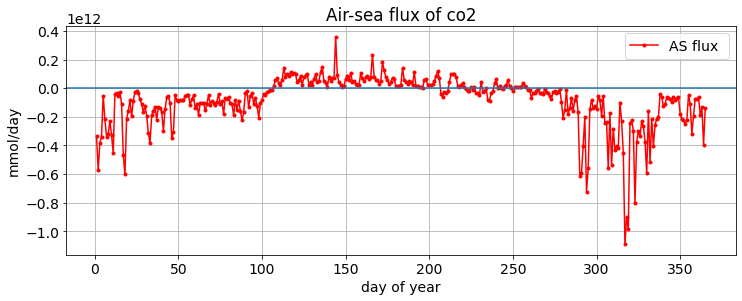

In [29]:
fact = 0.6
fig, axs = plt.subplots(1,1, figsize=(20*fact, 7*fact), facecolor='w', edgecolor='k')
# axs = axs.ravel()

# axs.plot(np.arange(1, dayslen+1,1),-1*w['PRD_DIC_mmol_day_tot_ar'][:], color = 'darkgreen',linestyle = '-', marker = '+', markersize = 3,\
#            label = 'phyto upt.')
# axs.plot(np.arange(1, dayslen+1,1),-1*w['UNC_DIC_mmol_day_tot_ar'][:], color = 'limegreen',linestyle = '-', marker = '+', markersize = 3,\
#            label = '(unc). phyto upt')

axs.plot(np.arange(1, dayslen+1,1),w['ASflux_mmol_day_tot_ar'][:], color = 'r',linestyle = '-', marker = '.', \
           label = 'AS flux ')

axs.axhline(y=0)
plt.title('Air-sea flux of co2')
#plt.yscale("log")
axs.grid()
axs.set_ylabel('mmol/day'); 
axs.set_xlabel('day of year'); 
plt.legend(loc = 'best')





In [30]:
print((w['DIC_mmol_tot_ar'][0]-w['DIC_mmol_tot_ar'][358])/w['DIC_mmol_tot_ar'][0])

-0.0076066563


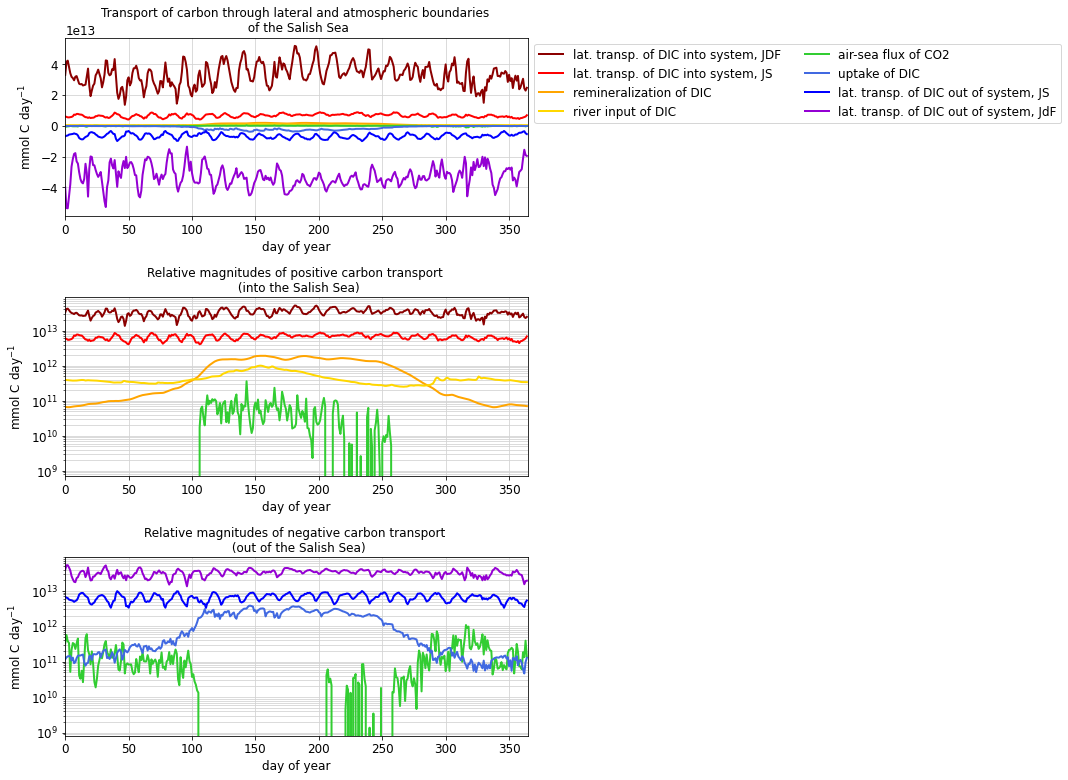

In [31]:
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 12}
lw = 2
fact = 0.5
days = np.arange(0,dayslen,1)
fig, axs = plt.subplots(3,1, figsize=(30*fact, 22*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(days,w['DIC_UT_mmol_day_pos_ar'][:], linestyle = '-', color = 'darkred', linewidth = lw, \
            label = 'lat. transp. of DIC into system, JDF') 
axs[0].plot(days,w['DIC_VT_mmol_day_pos_ar'][:], linestyle = '-', color = 'red', linewidth = lw, \
            label = 'lat. transp. of DIC into system, JS')
axs[0].plot(days,w['REM_DIC_mmol_day_tot_ar'][:], linestyle = '-', color = 'orange', linewidth = lw, \
            label = 'remineralization of DIC')
axs[0].plot(days,w['riv_DIC_mmol_day_tot_ar'][:], linestyle = '-', color = 'gold', linewidth = lw, \
            label = 'river input of DIC')
axs[0].plot(days,w['ASflux_mmol_day_tot_ar'][:], linestyle = '-', color = 'limegreen', linewidth = lw, \
            label = 'air-sea flux of CO2')
axs[0].plot(days,w['PRD_DIC_mmol_day_tot_ar'][:], linestyle = '-', color = 'royalblue', linewidth = lw, \
            label = 'uptake of DIC')
axs[0].plot(days,w['DIC_VT_mmol_day_neg_ar'][:], linestyle = '-', color = 'blue', linewidth = lw, \
            label = 'lat. transp. of DIC out of system, JS')
axs[0].plot(days,w['DIC_UT_mmol_day_neg_ar'][:], linestyle = '-', color = 'darkviolet', linewidth = lw, \
            label = 'lat. transp. of DIC out of system, JdF')


axs[1].plot(days,w['DIC_UT_mmol_day_pos_ar'][:], linestyle = '-', color = 'darkred', linewidth = lw, \
            label = 'lat. transp. of DIC into system, JDF') 
axs[1].plot(days,w['DIC_VT_mmol_day_pos_ar'][:], linestyle = '-', color = 'red', linewidth = lw, \
            label = 'lat. transp. of DIC into system, JS')
axs[1].plot(days,w['REM_DIC_mmol_day_tot_ar'][:], linestyle = '-', color = 'orange', linewidth = lw, \
            label = 'remineralization of DIC')
axs[1].plot(days,w['riv_DIC_mmol_day_tot_ar'][:], linestyle = '-', color = 'gold', linewidth = lw, \
            label = 'river input of DIC')
axs[1].plot(days,w['ASflux_mmol_day_tot_ar'][:], linestyle = '-', color = 'limegreen', linewidth = lw, \
            label = 'air-sea flux of CO2')

axs[1].set_yscale('log')
axs[1].grid()

axs[2].plot(days,(-1)*w['ASflux_mmol_day_tot_ar'][:], linestyle = '-', color = 'limegreen', linewidth = lw, \
            label = 'river input of DIC')
axs[2].plot(days,(-1)*w['PRD_DIC_mmol_day_tot_ar'][:], linestyle = '-', color = 'royalblue', linewidth = lw, \
            label = 'uptake of DIC')
axs[2].plot(days,(-1)*w['DIC_VT_mmol_day_neg_ar'][:], linestyle = '-', color = 'blue', linewidth = lw, \
            label = 'lat. transp. of DIC out of system, JS')
axs[2].plot(days,(-1)*w['DIC_UT_mmol_day_neg_ar'][:], linestyle = '-', color = 'darkviolet', linewidth = lw, \
            label = 'lat. transp. of DIC out of system, JdF')


axs[0].grid(True, which="both", ls="-", color = 'lightgray')
axs[0].legend(bbox_to_anchor = [1, 1], ncol = 2)
axs[0].set_xlim([0,365])
axs[0].set_ylabel('mmol C /day ')
axs[0].set_xlabel('day of year')

axs[1].grid(True, which="both", ls="-", color = 'lightgray')
axs[1].set_yscale('log')
axs[1].set_xlim([0,365])
axs[1].set_ylabel('mmol C /day ')
axs[1].set_xlabel('day of year')

axs[2].grid(True, which="both", ls="-", color = 'lightgray')
axs[2].set_yscale('log')
axs[2].set_xlim([0,365])
axs[2].set_ylabel('mmol C /day ')
axs[2].set_xlabel('day of year')

####
# axs[1].plot(days,PI9_JDFtottrans_pos, linestyle = ':', color = 'darkblue', linewidth = 2, \
#             label = 'preind. lat. transport \n of carbon into system, JDF') 
# axs[1].plot(days,PI9_JStottrans_pos, linestyle = ':', color = 'blue', linewidth = 1, \
#             label = 'preind. lat. transport \n of carbon into system JS') 
# axs[1].plot(days,BR3_JDFtottrans_pos, linestyle = '-', color = 'darkblue', linewidth = 2, \
#             label = 'present-day lat. transport \n of carbon into system, JDF') 
# axs[1].plot(days,BR3_JStottrans_pos, linestyle = ':', color = 'blue', linewidth = 1, \
#             label = 'present-day lat. transport \n of carbon into system JS') 
# axs[1].plot(days,BR3_flx_pos, color = 'skyblue', label =  'present-day air-sea flux \n (into system)')
# axs[1].plot(days,PI9_flx_pos, color = 'skyblue', linestyle = ':', \
#          label =  'preind. air-sea flux \n (into system)')
# axs[1].axhline(y=0)
# axs[1].set_xlim([0,365])
# axs[1].set_ylabel('Gmol C')
# axs[1].set_xlabel('day of year')
# axs[1].set_yscale('log')
# axs[1].grid(True, which="both", ls="-", color = 'lightgray')

####

#axs.set_yscale('log')
# axs[2].plot(days,(-1)*PI9_JDFtottrans_neg, linestyle = ':', color = 'crimson', linewidth = 2, \
#             label = 'preind. lat. transport \n of carbon out of system, JDF') 
# axs[2].plot(days,(-1)*PI9_JStottrans_neg, linestyle = ':', color = 'red', linewidth = 1, \
#             label = 'preind. lat. transport \n of carbon out of system JS') 
# axs[2].plot(days,(-1)*BR3_JDFtottrans_neg, linestyle = '-', color = 'crimson', linewidth = 2, \
#             label = 'present-day lat. transport \n of carbon out of system, JDF') 
# axs[2].plot(days,(-1)*BR3_JStottrans_neg, linestyle = '-', color = 'red', linewidth = 1, \
#             label = 'present-day lat. transport \n of carbon out of system JS') 
# axs[2].plot(days,(-1)*BR3_flx_neg, color = 'orange', label =  'present-day air-sea flux \n (out of system)')
# axs[2].plot(days,(-1)*PI9_flx_neg, color = 'orange', linestyle = ':', \
#          label =  'preind. air-sea flux \n (out of system)')
# axs[2].set_xlim([0,365])
# axs[2].set_ylabel('Gmol C day$^{-1}$')
# axs[2].set_xlabel('day of year')
# axs[2].set_yscale('log')
# axs[2].set_ylim([1e-4,1e2])
# axs[2].grid(True, which="both", ls="-", color = 'lightgray')


axs[0].set_ylabel('mmol C day$^{-1}$')
axs[1].set_ylabel('mmol C day$^{-1}$')
axs[2].set_ylabel('mmol C day$^{-1}$')


axs[0].set_title('Transport of carbon through lateral and atmospheric boundaries \n of the Salish Sea', fontsize = 12)
axs[1].set_title('Relative magnitudes of positive carbon transport \n (into the Salish Sea)', fontsize = 12)
axs[2].set_title('Relative magnitudes of negative carbon transport \n (out of the Salish Sea)', fontsize = 12)

plt.tight_layout()
#plt.suptitle('Mean transport of carbon through the SalishSeaCast boundaries by yearday', fontsize = 18)

## Comentary:

- A) Daily mean domain volume. It changes quite a bit (even with higher-frequency tides largely filtered out in this view); maximum ~  (2290-2275)/2275 = 0.65%. SNAP volume (instantaneous volume taken at a consistent point in day) would (likely) show even larger amplitude variability
- B) DIC content of the domain: SNAP and mean daily
        - SNAP is "instantaneous at midnight, for a given day, calculated by XIOS as "([instantaneous DIC at midnight] * [instantaneous e3t at midnight])"
        - mean daily DIC is calculated as [daily mean DIC concentration] * [daily mean e3t])
- B) As expected, the SNAP content has larger amplitudes due to not filtering out high-frequency tide cycles. DIC content is decreasing, which makes sense for the time of year - lots of carbon is leaving the surface, the deep waters have a lower carbon content due to downwelling. 
- C) Magnitudes of sources and sinks except lateral fluxes - riverine DIC input is always a source, as is remineralization, phytoplankton uptake is a sink, uncoupled carbon uptake by phyto is (so far, in winter) 4 orders of magnitude lower (1e7 mmol/day vs 1e11 mmol/day) than normal phyto uptake, AS flux is a sink but we expect it to turn to a source in summer. AS flux shows the largest amplitude of variability. 
- D) All sources and sinks. JdF fluxes dwarf everything, JS is second in magnitude (basically expected) 

### checking that the budget adds up.


- **DIC_E3TSNAP** gives instantaneous DIC concentration * e3t at the end of the day.
- we use it to calculate **DIC_SNAP_mmol_tot_ar** - instantaneous total carbon content of the domain at the end of the day
- we also add all the sources and sinks from the model to give us **daychange_mmol_day_tot_ar**.
- The change in the model carbon content should be the sum of the carbon sources and the sinks
- So, (**DIC_SNAP_mmol_tot_ar[jan 2]** - **DIC_SNAP_mmol_tot_ar[jan 1]**) should be equal to  **daychange_mmol_day_tot_ar[jan 2]**
- we can plot every day's change in **DIC_SNAP_mmol_tot_ar** (called **SNAP_diff**)  against **daychange_mmol_day_tot_ar** - must be careful with off-by-one-day errors, but these should be equal. We do not have **SNAP_diff** for jan 1, as we do not know instantaneous carbon content at end of Dec 31, 2016. 
- we can also plot DIC_SNAP_mmol_tot_ar[jan 1] + the sum of the subsequent days' daily differences against **DIC_SNAP_mmol_tot_ar** to see if these line up



In [ ]:
daily_diff = w['daychange_mmol_day_tot_ar'][:]
daily_SNAP = w['DIC_SNAP_mmol_tot_ar'][:]

print(np.shape(daily_diff))

SNAP_diff = np.zeros_like(daily_SNAP)
day1_SNAP_plus_cum_diff = np.zeros_like(daily_diff)


day1_SNAP_plus_cum_diff[0] = daily_SNAP[0]

for i in range(1,dayslen):
    
    day1_SNAP_plus_cum_diff[i] = \
    day1_SNAP_plus_cum_diff[0] + np.nansum(daily_diff[1:i+1])
    
day1_SNAP_plus_cum_diff[day1_SNAP_plus_cum_diff == 0 ] = np.nan


for i in range(1,dayslen):
    SNAP_diff[i] = daily_SNAP[i] - daily_SNAP[i-1]
    
SNAP_diff[0] = np.nan

print(np.shape(SNAP_diff))
print(dayslen)

In [ ]:
fact = 0.7
fig, axs = plt.subplots(2,1, figsize=(20*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(np.arange(1,dayslen+1,1),w['DIC_mmol_tot_ar'][:], color = 'grey',linestyle = '-',  marker = 'o', \
           label = 'daily average DIC ')

axs[0].plot(np.arange(1,dayslen+1,1),day1_SNAP_plus_cum_diff, color = 'r',linestyle = '-', linewidth = 4, marker = 'o', markersize = 8, \
           label = 'estimate obtained by \n cumulatively adding \n sources and sinks of DIC \n to starting point (end-of-day JAN 1)')
axs[0].plot(np.arange(1,dayslen+1,1),w['DIC_SNAP_mmol_tot_ar'][:], color = 'k',linestyle = '-', linewidth = 1, marker = 'o', markersize = 4,\
           label = 'end-of-day SNAP DIC content')
axs[0].legend(bbox_to_anchor = [1, 1])


axs[1].plot(np.arange(1,dayslen+1,1),daily_diff, color = 'r',linestyle = '-', linewidth = 4, marker = 'o', markersize = 8, label = 'daily calculated SMS')
axs[1].plot(np.arange(1,dayslen+1,1),SNAP_diff, color = 'k',linestyle = '-', linewidth = 1, marker = 'o', markersize = 4, label = 'daily difference in EOD \n instantaneous carbon content ')

axs[0].set_title('total carbon in system \n black is output by model (end-of-day snapshot) \n red is jan 1 EOD snapshot + subsequent calculated SMS  \n (eg jan 3 value is jan1 EOD SNAP + jan2 SMS + jan 3 SMS)')
axs[1].set_title('daily sources and sinks \n black is daily difference in model-output EOD carbon content (eg jan 2 value is jan2 EOD-jan1 EOD) \n , red is calculated sources and sinks (eg jan 2 value is jan2 SMS) ')
axs[0].set_ylabel('mmol C')
axs[0].set_ylabel('mmol C/day')

for i in range(0,2):
    axs[i].grid();
    axs[i].set_xlabel('day of year')
    axs[i].set_xlim([1,dayslen])
    axs[i].legend(bbox_to_anchor = [1 ,1])
plt.tight_layout()


####  Visually these estimates seem to line up very well; quantitatively, how close are they?

Let's look at the percent difference in the total carbon content calculated 2 ways, and also at the percent difference in implied SMS (difference in EOD reported values by E3TSNAP from day to day) and the calculated daily SMS. 

The total difference in the total carbon content calculated 2 ways is small (order 1/100 of a %) but potentially increasing. 
  

In [ ]:
fact = 0.7
fig, axs = plt.subplots(2,1, figsize=(20*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

SNAPest = w['DIC_SNAP_mmol_tot_ar'][:]
SMSest = day1_SNAP_plus_cum_diff

axs[0].plot(np.arange(1,dayslen+1,1), (((SNAPest)-(SMSest)))/((SNAPest+SMSest)/2) *100)

SNAPest = SNAP_diff
SMSest = daily_diff

axs[1].plot(np.arange(1,dayslen+1,1), np.abs(SNAPest-SMSest)/((SNAPest+SMSest)/2) *100)


ax2 = axs[1].twinx()  # instantiate a second axes that shares the same x-axis

#color = 'tab:blue'
#ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
#ax2.plot(t, data2, color=color)
ax2.plot(np.arange(1,dayslen+1,1),daily_diff, color = 'r',linestyle = '-', linewidth = 4, marker = 'o', markersize = 8, label = 'daily calculated SMS')
ax2.plot(np.arange(1,dayslen+1,1),SNAP_diff, color = 'k',linestyle = '-', linewidth = 1, marker = 'o', markersize = 4, label = 'daily difference in EOD \n instantaneous carbon content ')
ax2.plot(np.arange(1,dayslen+1,1),np.zeros_like(SNAP_diff), color = 'b')
ax2.set_ylabel('SMS carbon, mmol/day')
# axs[1].plot(np.arange(1,dayslen+1,1),daily_diff, color = 'r',linestyle = '-', linewidth = 4, marker = 'o', markersize = 8, label = 'daily calculated SMS')
# axs[1].plot(np.arange(1,dayslen+1,1),SNAP_DIFF, color = 'k',linestyle = '-', linewidth = 1, marker = 'o', markersize = 4, label = 'daily difference in EOD \n instantaneous carbon content ')

axs[0].set_title('perc. difference between (daily EOD carbon content output by model) and \n (day 1 EOD carbon content + subsequent calculated sources/sinks)')
axs[1].set_title('perc. difference between (daily difference in EOD carbon content output by model) and \n (calculated sources and sinks) ')
axs[0].set_ylabel('% of total carbon content')
axs[1].set_ylabel('% of daily SMS')

for i in range(0,2):
    axs[i].grid();
    axs[i].set_xlabel('day of year')
    axs[i].set_xlim([1,dayslen])
    axs[i].legend(bbox_to_anchor = [1 ,1])
plt.tight_layout()


## So, how close is our budget?

In most cases, the calculated sources and sinks are at least visually quite similar, as we can see. The mean magnitude of teh sources and sinks (mean of abs(SMS)) is ~8.21362108E+12. The large spikes in percent difference (shown above in blue) occur when the net sources and sinks are close to 0 (and sometimes on the opposite sides of 0). Disregarding where |SMS| < 1e12, the mean % difference is 0.987%. The mean difference between the 2 ways of calculating the sources and the sinks, not disregarding small sources and sinks, is 3%.  This is close, but is it close enough?


In [ ]:
SNAPest = SNAP_diff
SMSest = daily_diff

#print(np.sort((daily_diff)))
mean_mag = (np.mean(np.abs(daily_diff[1:-1])))
print('mean calculated daily |SMS| (mmol/day):')
print(f"{Decimal(int(mean_mag)):.8E}") 
print('mean daily |SMS|from snap differences(mmol/day):')
print(f"{Decimal(int(np.nanmean(np.abs(SNAP_diff[1:-1])))):.8E}") 
print('')
#print(np.sort(daily_diff))

percdiff = np.abs(SNAPest-SMSest)/((SNAPest+SMSest)/2) *100
print('mean % diff between SMS calculated and SMS from SNAP')
print(np.mean(percdiff))             
# print('mean % diff disregarding small SMS (  |SMS| < 1e12 mmol/day)')
# percdiff[daily_diff < 1e12] = np.nan
# print(np.nanmean(percdiff))    

# #print(np.abs(SNAPest-SMSest)/((SNAPest+SMSest)/2) *100)

# SNAPest = np.sum(SNAP_diff[1:-1])
# SMSest = np.sum(daily_diff[1:-1]) 

# print('sum total SMS over timeperiod SNAP')
# print(f"{Decimal(int(SNAPest)):.8E}") 
# print('sum total SMS over timeperiod calculated')
# print(f"{Decimal(int(SMSest)):.8E}") 
# percdiff_total = np.abs(np.abs(SNAPest-SMSest)/((SNAPest+SMSest)/2)) *100
# print('% difference in the above two numbers ' )
# print(percdiff_total)


## Could the 'missing flux' be lateral diffusion?

Coefficient of lateral diffusion:
1.5 m2/s

total lateral diffusion (mmol/day) = coeff_ld * ∇ DIC * cross-sectional area * seconds/day



In [ ]:
SNAPest = w['DIC_SNAP_mmol_tot_ar'][:]
SMSest = day1_SNAP_plus_cum_diff

fact = 0.7
fig, axs = plt.subplots(2,1, figsize=(20*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

SNAPest = w['DIC_SNAP_mmol_tot_ar'][:]
SMSest = day1_SNAP_plus_cum_diff

axs[0].plot(np.arange(1,dayslen+1,1), (SNAPest - SMSest))

mean_budgdiff = np.zeros_like(SNAPest)
for i in range(0,dayslen):
    mean_budgdiff[i] = (SNAPest[i]-SMSest[i])/(i+1)

axs[0].set_title('total difference between (daily EOD carbon content output by model) and \n (day 1 EOD carbon content + subsequent calculated sources/sinks)')
axs[0].set_ylabel('total carbon content difference (mmol)')
axs[1].set_title('mean daily budget gap (mmol/day)')
axs[1].set_ylabel('mean daily budget gap (mmol/day)')


axs[1].plot(np.arange(1,dayslen+1,1), (mean_budgdiff))

for i in range(0,2):
    axs[i].grid();
    axs[i].set_xlabel('day of year')
    axs[i].set_xlim([1,dayslen])
    axs[i].legend(bbox_to_anchor = [1 ,1])
plt.tight_layout()


In [ ]:
print('mmol/day budget gap:')
print('([total budget gap]/no. of days)')
budgetgap = int((SNAPest[dayslen-1] - SMSest[dayslen-1])/dayslen)
print(f"{Decimal(budgetgap):.8E}")
#print(f"{Decimal(int(SNAPest[dayslen-1] - SMSest[dayslen-1]):.8E}") 


In [ ]:

#total lateral diffusion (mmol/day) = 
#coeff_ld * ∇ DIC * cross-sectional area * seconds/day

print('total lateral diffusion (mmol/day) = ')
print('coeff_ld (m2/s) * ∇ DIC (mmol/m3/m) * cross-sectional area (m2) * seconds/day')
print('')
#mmk = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
#print(mmk)
e2t_here = (mmk['e2t'][0,:,20])
e3t_here = (mmk['e3t_0'][0,:,:,20])
tmask_here = mmk['tmask'][0,:,:,20]
e2t_here_broad = np.zeros_like(e3t_here)
for i in range(0,40):
    e2t_here_broad[i,:] = e2t_here

jdf_crossection = (e2t_here_broad*tmask_here*e3t_here)

tot_jdf_cross = (np.nansum(jdf_crossection))


coeff_ld = 1.5

grad_DIC = 10
TLD = coeff_ld * grad_DIC * tot_jdf_cross * sid

print(f'Assuming a DIC gradient of {grad_DIC} umol/m across the JDF boundary,')
print('our BOE tot. lat diff would be')
(print(f"{Decimal(TLD):.8E} mmol/day"))
print()

grad_DIC = 1
TLD = coeff_ld * grad_DIC * tot_jdf_cross * sid

print(f'Assuming a DIC gradient of {grad_DIC} umol/m across the JDF boundary,')
print('our BOE tot. lat diff would be')
(print(f"{Decimal(TLD):.8E} mmol/day"))
print()

grad_DIC = 0.05
TLD = coeff_ld * grad_DIC * tot_jdf_cross * sid

print(f'Assuming a DIC gradient of {grad_DIC} umol/m across the JDF boundary,')
print('our BOE tot. lat diff would be')
(print(f"{Decimal(TLD):.8E} mmol/day"))

print(f'({grad_DIC} umol/m = {grad_DIC*1000} umol/km)')
print()
print('our daily budget gap is ')
(print(f"{Decimal(budgetgap):.8E} mmol/day"))

#total lateral diffusion (mmol/day) = 
#coeff_ld * ∇ DIC * cross-sectional area * seconds/day

## what is the residence time of our system? 


In [ ]:
tot_in_dom = w['DIC_SNAP_mmol_tot_ar'][:]

print('total mmol in system - mean (mmol)')
print(np.nanmean(tot_in_dom))

print('total transport into system - mean (mmol/day)')
tot_pos = w['DIC_UT_mmol_day_pos_ar'][:]+w['DIC_VT_mmol_day_pos_ar'][:]
print(np.nanmean(tot_pos))

print('total transport out of system - mean (mmol/day)')
tot_neg = w['DIC_UT_mmol_day_neg_ar'][:]+w['DIC_VT_mmol_day_neg_ar'][:]
print(np.nanmean(tot_neg))

print('simple res time based on pos. transp.')
print(np.nanmean(tot_in_dom)/np.nanmean(tot_pos))

print('simple res time based on neg. transp.')
print(np.nanmean(tot_in_dom)/np.nanmean(tot_neg))

In [ ]:
print(w)